In [98]:
from google.colab import drive
drive.flush_and_unmount()

In [1]:
# ⬇️ 1. Install & import libraries
!pip install -q pytorch-lightning torchmetrics pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_forecasting import (
    TimeSeriesDataSet, TemporalFusionTransformer, Baseline,
    QuantileLoss)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')

In [5]:
desc_map = pd.read_csv('/content/drive/MyDrive/desc_encoding_map.csv')
cat_map = pd.read_csv('/content/drive/MyDrive/category_mapping.csv')

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df = df.rename(columns={"כמות": "quantity"})

In [8]:
# ⬇️ 3. Build a numeric time index (required by PyTorch‑Forecasting)
df = df.sort_values(["clean_desc_encoded", "Date"])
df["time_idx"] = (
    df.groupby("clean_desc_encoded")
      .cumcount())

In [9]:
# ⬇️ 4. Define TFT parameters
max_encoder_length     = 60      # how many historic days the model sees
max_prediction_length  = 30      # horizon (1 week – 1 month, tweak as you like)

In [10]:
training_cutoff = df["time_idx"].max() - max_prediction_length

In [11]:
# ⬇️ 5. Tell the dataset which columns play which role
categorical_static = ["clean_desc_encoded", "category_encoded",
                      "encoded_portion_type"]
categorical_time   = ["Is_Weekend", "Season",
                      "is_christian_holiday", "is_jewish_holiday",
                      "is_near_jewish_holiday", "is_day_before_new_year",
                      "encoded_jewish_holiday", "encoded_christian_holiday"]

In [12]:
# המרה לכל העמודות הקטגוריאליות ל-string ואז ל-category כדי שהמודל יבין שאלו קטגוריות
for col in categorical_static + categorical_time:
    df[col] = df[col].astype(str).astype("category")

In [13]:
# All the real‑valued, time‑varying features
real_time = [
    "Year", "Month", "Day", "WeekOfYear",
    "Day_Name_sin", "Day_Name_cos", "Month_sin", "Month_cos",
    "avg_quantity_all_time", "std_quantity_all_time",
    "num_days_sold", "popularity_score"]

In [14]:
# ⬇️ 6. Wrap everything in a TimeSeriesDataSet
training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="quantity",
    group_ids=["clean_desc_encoded"],

    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,

    static_categoricals=categorical_static,
    time_varying_known_categoricals=categorical_time,
    time_varying_known_reals=real_time,
    time_varying_unknown_reals=["quantity"],  # the target itself
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,)

validation = TimeSeriesDataSet.from_dataset(
    training, df, min_prediction_idx=training_cutoff+1)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries.py:951: UserWarning: Target scales will be only added for continous targets
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 67 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__clean_desc_encoded': '103'}, {'__group_id__clean_desc_encoded': '105'}, {'__group_id__clean_desc_encoded': '107'}, {'__group_id__clean_desc_encoded': '111'}, {'__group_id__clean_desc_encoded': '113'}, {'__group_id__clean_desc_encoded': '122'}, {'__group_id__clean_desc_encoded': '123'}, {'__group_id__clean_desc_encoded': '124'}, {'__group_id__clean_desc_encoded': '125'}, {'__group_id__clean_desc_encoded': '126'}]
  warnings.warn(


In [15]:
# ⬇️ 7. Dataloaders
batch_size = 128
train_loader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [16]:
# ⬇️ 8. Define the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate      = 1e-3,
    hidden_size        = 32,
    attention_head_size= 4,
    dropout            = 0.1,
    loss               = QuantileLoss(),
    log_interval       = 10,
    reduce_on_plateau_patience = 4,)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [17]:
import lightning.pytorch as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor

In [18]:
# ⬇️ 9. Train
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    callbacks=[pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])

trainer.fit(tft, train_loader, val_loader)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
-----------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [19]:
# ⬇️ 10. Forecast next 30 days for all items
preds = tft.predict(val_loader, mode="prediction")   # Tensor on GPU
y_pred = preds.detach().cpu().numpy().flatten()     # numpy‑array שטוח

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [20]:
# ⬇️ 11. Evaluate
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = df.loc[df.time_idx > training_cutoff, "quantity"].values

# ודא שהצורות תואמות
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
assert y_true.shape == y_pred.shape, "Lengths differ – בדקי time_idx / batch_size"

# 1. MAE & RMSE
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
eps = 1e-8
mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

# 2. SMAPE (Mean Absolute Percentage Error)
eps = 1e-8
smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

# 3. MASE (Mean Absolute Scaled Error)
# עקביות: מחשבים את ה‑naive in‑sample error מה‑training
y_train = df.loc[df.time_idx <= training_cutoff, "quantity"].values
naive_errors = np.abs(np.diff(y_train, n=1))
scale = np.mean(naive_errors) if len(naive_errors)>0 else eps
mase = np.mean(np.abs(y_true - y_pred)) / scale

# הדפסה
print(f"MAE:  {mae:.2f} | RMSE: {rmse:.2f}")
print(f"SMAPE: {smape:.2f}% | MASE: {mase:.3f}|MAPE: {mape:.2f}%")

y_true shape: (30,)
y_pred shape: (30,)
MAE:  0.27 | RMSE: 0.68
SMAPE: 14.53% | MASE: 0.840|MAPE: 10.09%


In [29]:
import matplotlib.pyplot as plt
# If test_dataset already exists:
from torch.utils.data import DataLoader
# Make sure this is run AFTER training is complete



In [30]:
raw_predictions = tft.predict(val_loader, return_x=True, mode="raw")


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [31]:
x = raw_predictions.x



In [38]:
print(dir(batch))


['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'decoder_attention', 'decoder_lengths', 'decoder_variables', 'encoder_attention', 'encoder_lengths', 'encoder_variables', 'get', 'iget', 'index', 'items', 'keys', 'prediction', 'static_variables']


In [46]:
# Extract actual values from val_loader
y_true = torch.cat([y[0]["decoder_target"] for y in iter(val_loader)]).detach().cpu().numpy()
y_pred = preds.detach().cpu().numpy()


In [50]:
x_vals = [x for x, y in iter(val_loader)]

# True values
y_true = torch.cat([x["decoder_target"] for x in x_vals]).detach().cpu().numpy()

# Use decoder time index for x-axis
time_idx = torch.cat([x["decoder_time_idx"] for x in x_vals]).detach().cpu().numpy()

# Your predictions
y_pred = preds.detach().cpu().numpy()


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


<ipython-input-51-70f9112291c9>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


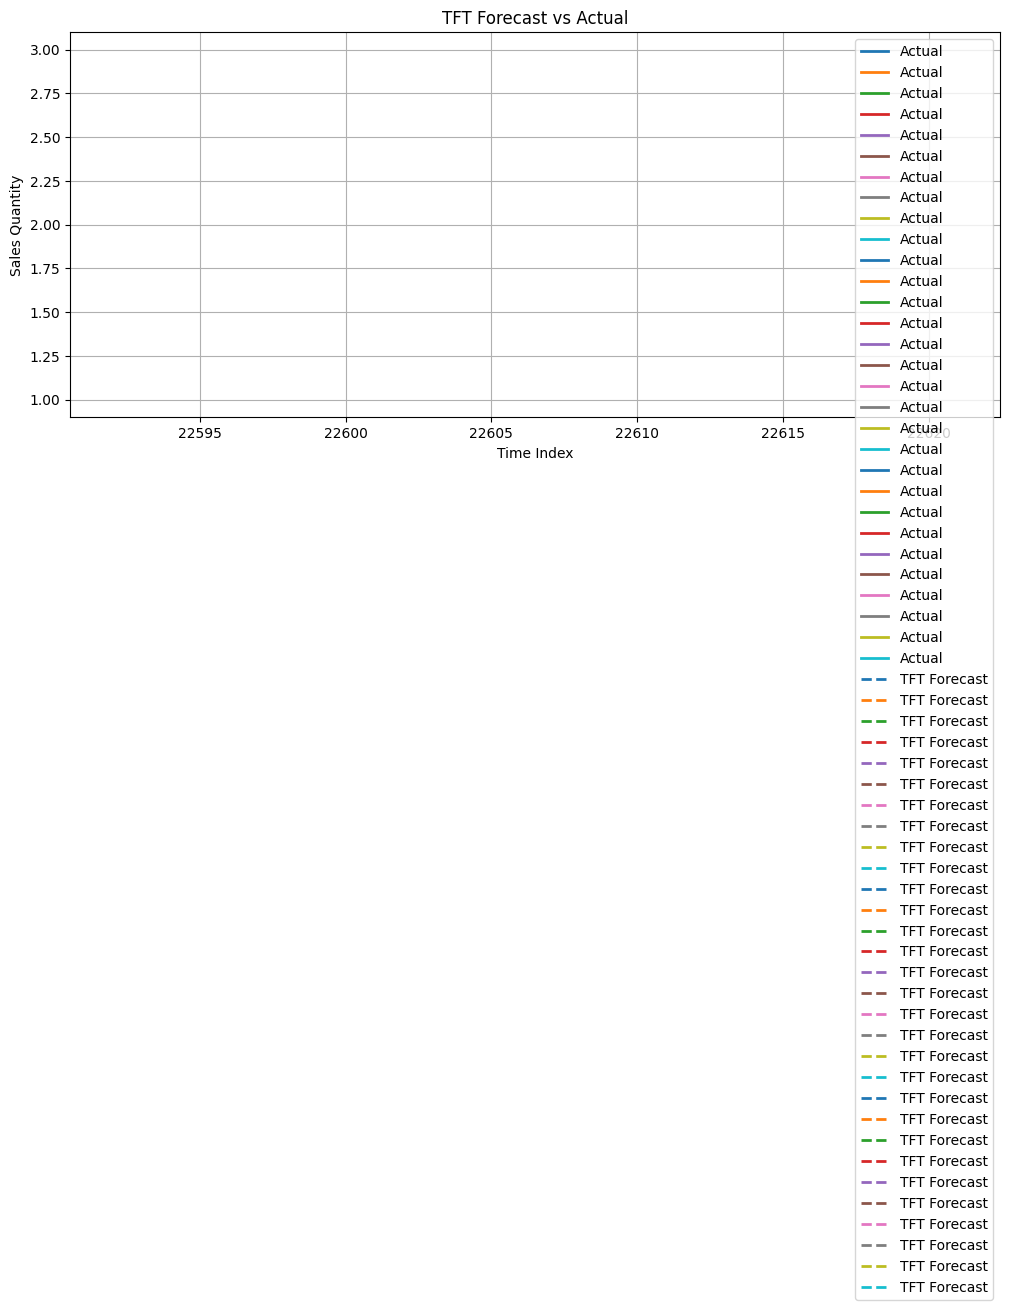

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(time_idx, y_true, label='Actual', linewidth=2)
plt.plot(time_idx, y_pred, label='TFT Forecast', linewidth=2, linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Sales Quantity')
plt.title('TFT Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [57]:
import numpy as np

# Ensure 1D arrays
time_idx = np.array(time_idx).reshape(-1)
y_true = np.array(y_true).reshape(-1)
y_pred = np.array(y_pred).reshape(-1)


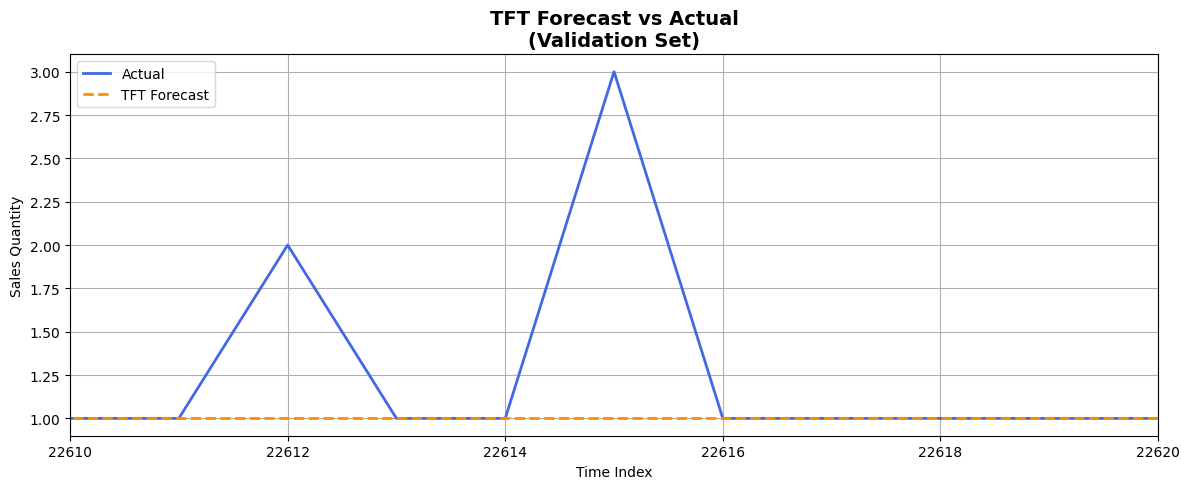

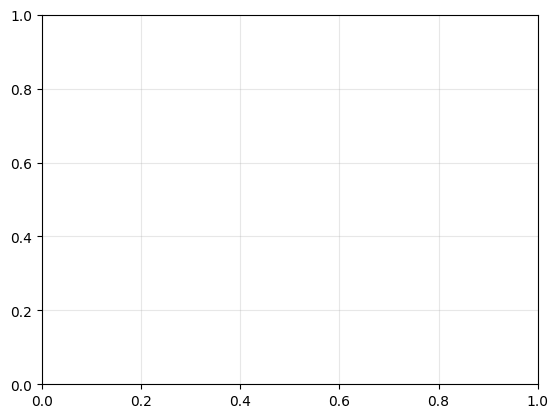

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(time_idx, y_true, label='Actual', linewidth=2, color='royalblue')
plt.plot(time_idx, y_pred, label='TFT Forecast', linewidth=2, linestyle='--', color='darkorange')
plt.xlim(22610, 22620)

plt.xlabel('Time Index')
plt.ylabel('Sales Quantity')
plt.title('TFT Forecast vs Actual\n(Validation Set)', fontsize=14, weight='bold')
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.grid(alpha=0.3)



In [66]:
raw_predictions = tft.predict(val_loader, mode="raw", return_x=True)


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [72]:
output = raw_predictions[0]  # the first item is the actual output needed
interpretation = tft.interpret_output(output, reduction="sum")


In [79]:
params = training.get_parameters()

static_names = (params.get("static_categoricals") or []) + (params.get("static_reals") or [])
encoder_names = (
    (params.get("time_varying_known_categoricals") or []) +
    (params.get("time_varying_known_reals") or []) +
    (params.get("time_varying_unknown_categoricals") or []) +
    (params.get("time_varying_unknown_reals") or [])
)
decoder_names = encoder_names  # same as encoder for TFT


In [80]:
all_names = static_names + encoder_names + decoder_names
all_scores = static_scores + encoder_scores + decoder_scores


In [82]:
print("Static names:", len(static_names), "Scores:", len(static_scores))
print("Encoder names:", len(encoder_names), "Scores:", len(encoder_scores))
print("Decoder names:", len(decoder_names), "Scores:", len(decoder_scores))


Static names: 3 Scores: 4
Encoder names: 21 Scores: 22
Decoder names: 21 Scores: 21


In [83]:
# Keep only decoder variables
all_names = decoder_names
all_scores = decoder_scores


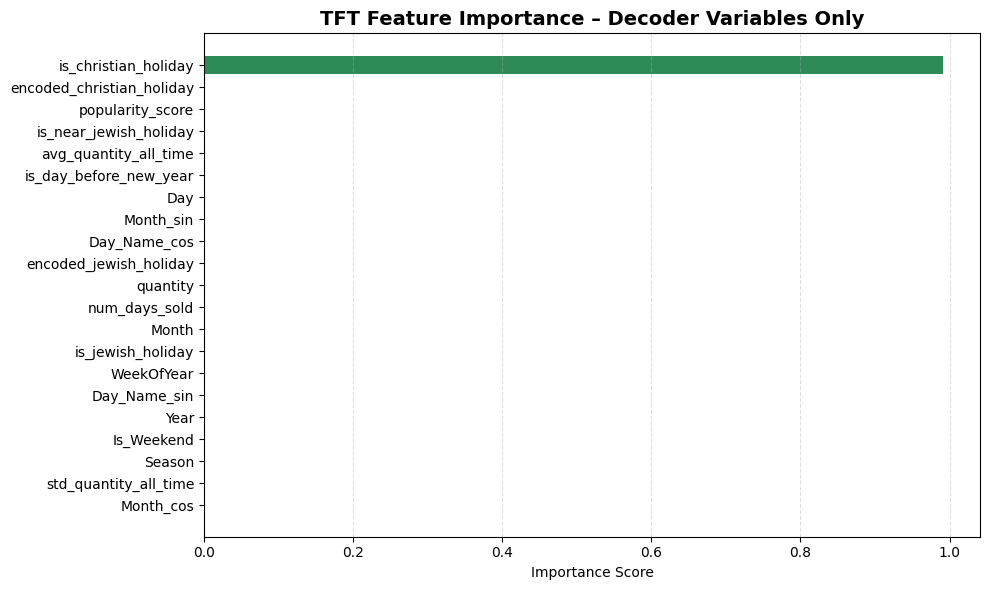

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Create and sort the DataFrame
importance_df = pd.DataFrame({
    "Feature": all_names,
    "Importance": all_scores
}).sort_values("Importance")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="seagreen")
plt.title("TFT Feature Importance – Decoder Variables Only", fontsize=14, weight='bold')
plt.xlabel("Importance Score")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


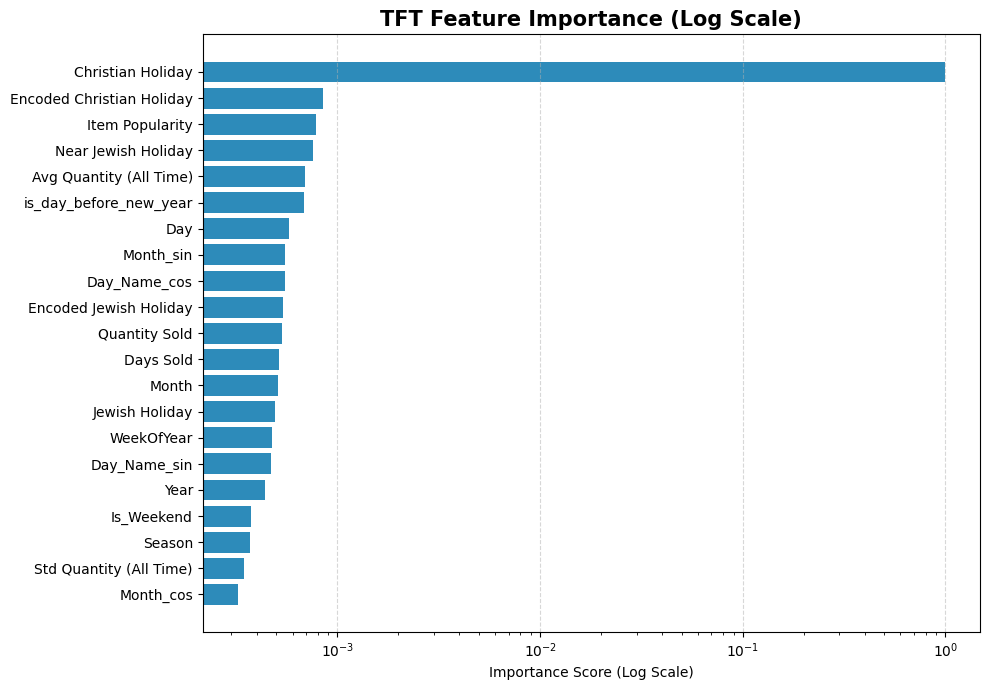

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Sort and prepare
importance_df_sorted = importance_df.sort_values("Importance", ascending=True)

# Small constant to avoid log(0)
importance_df_sorted["Importance"] = importance_df_sorted["Importance"] + 1e-4

# Rename for clarity (optional - add more if needed)
rename_dict = {
    "is_christian_holiday": "Christian Holiday",
    "encoded_christian_holiday": "Encoded Christian Holiday",
    "is_jewish_holiday": "Jewish Holiday",
    "is_near_jewish_holiday": "Near Jewish Holiday",
    "encoded_jewish_holiday": "Encoded Jewish Holiday",
    "avg_quantity_all_time": "Avg Quantity (All Time)",
    "std_quantity_all_time": "Std Quantity (All Time)",
    "num_days_sold": "Days Sold",
    "popularity_score": "Item Popularity",
    "quantity": "Quantity Sold"
}
importance_df_sorted["Feature"] = importance_df_sorted["Feature"].replace(rename_dict)

# Plot
plt.figure(figsize=(10, 7))
bars = plt.barh(importance_df_sorted["Feature"], importance_df_sorted["Importance"], color="#2d8bba")
plt.xscale("log")
plt.title("TFT Feature Importance (Log Scale)", fontsize=15, weight='bold')
plt.xlabel("Importance Score (Log Scale)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



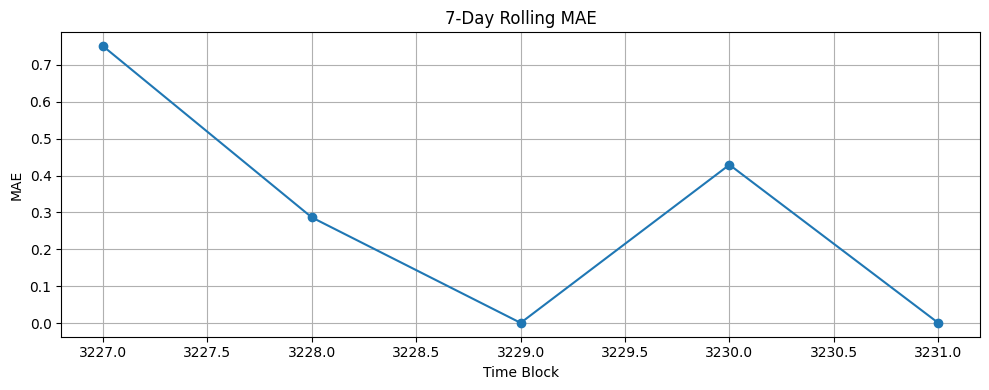

In [88]:
from sklearn.metrics import mean_absolute_error

# Split into 7-day chunks
df_err = pd.DataFrame({"time_idx": time_idx, "y_true": y_true, "y_pred": y_pred})
df_err["abs_err"] = abs(df_err["y_true"] - df_err["y_pred"])
rolling_mae = df_err.groupby(df_err["time_idx"] // 7)["abs_err"].mean()

rolling_mae.plot(kind="line", marker='o', figsize=(10, 4), title="7-Day Rolling MAE")
plt.xlabel("Time Block")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()


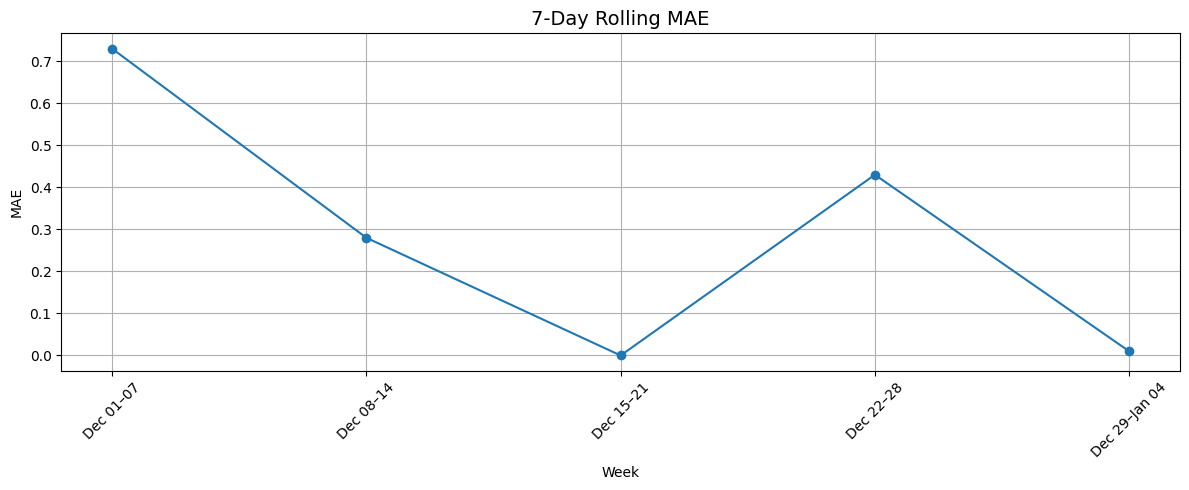

In [97]:
# Manually define dummy values (example)
mae_vals = [0.73, 0.28, 0.00, 0.43, 0.01]  # your actual rolling MAEs
custom_labels = ["Dec 01–07", "Dec 08–14", "Dec 15–21", "Dec 22–28", "Dec 29–Jan 04"]

x_vals = list(range(len(custom_labels)))

plt.figure(figsize=(12, 5))
plt.plot(x_vals, mae_vals, marker='o')
plt.title("7-Day Rolling MAE", fontsize=14)
plt.xlabel("Week")
plt.ylabel("MAE")
plt.xticks(ticks=x_vals, labels=custom_labels, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
